<a href="https://colab.research.google.com/github/Swikruti23/Final-Year-Project/blob/main/Major_Project_EC_Btd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explainable ConvNeXt for Breast Tumor Detection.

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing required packages

In [25]:
!pip install -q torch torchvision torchaudio
!pip install -q timm  # For ConvNeXt model
!pip install -q grad-cam  # For Grad-CAM explanations
!pip install -q shap  # For SHAP explanations
!pip install -q lime  # For LIME explanations
!pip install -q scikit-learn
!pip install -q matplotlib seaborn
!pip install -q pillow
!pip install -q tqdm

IMPORTS

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

# Model imports
import timm
from timm.models import convnext

# Explainability imports
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


DATA PREPARATION

In [27]:
class BreastTumorDataset(Dataset):
    """Custom Dataset for Breast Tumor Images"""

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def prepare_data(data_dir, img_size=224):
    """
    Prepare data for training
    Args:
        data_dir: Path to dataset directory
        img_size: Image size for ConvNeXt
    """

    # Collect all image paths and labels
    image_paths = []
    labels = []

    # Assuming directory structure:
    # data_dir/
    #   benign/
    #   malignant/

    classes = ['benign', 'malignant']
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_dir, img_name))
                    labels.append(class_to_idx[class_name])

    # 80-20 train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Further split training into train and validation (80-20 of training data)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Test samples: {len(X_test)}")

    # Data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # No augmentation for validation and test
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = BreastTumorDataset(X_train, y_train, train_transform)
    val_dataset = BreastTumorDataset(X_val, y_val, test_transform)
    test_dataset = BreastTumorDataset(X_test, y_test, test_transform)

    return train_dataset, val_dataset, test_dataset, classes

MODEL ARCHITECTURE

In [28]:
class ConvNeXtBreastTumor(nn.Module):
    def __init__(self, num_classes=2, model_name='convnext_tiny', pretrained=True, dropout=0.3):
        super().__init__()
        self.base_model = timm.create_model(model_name, pretrained=pretrained)
        num_features = self.base_model.head.in_features
        self.base_model.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout/2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout/2),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        # 1) extract backbone features (no head)
        features = self.base_model.forward_features(x)  # [batch, C, H, W]
        # 2) global average pool
        pooled = features.mean(dim=[2, 3])              # [batch, C]
        # 3) classification head
        out = self.base_model.head(pooled)              # [batch, num_classes]
        return out


TRAINING FUNCTIONS

In [29]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    predictions = []
    targets = []

    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(targets, predictions)

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    predictions = []
    targets = []
    probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            prob = F.softmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            probs.extend(prob.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(targets, predictions)

    return epoch_loss, epoch_acc, predictions, targets, probs

def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """Complete training loop"""

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc, _, _, _ = validate_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Save metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_convnext_breast_tumor.pth')
            print(f"Model saved! Best Val Acc: {best_val_acc:.4f}")

    return train_losses, train_accs, val_losses, val_accs

EVALUATION FUNCTIONS

In [30]:
def evaluate_model(model, test_loader, device, classes):
    """Comprehensive model evaluation"""

    model.eval()
    predictions = []
    targets = []
    probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            prob = F.softmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())
            probs.extend(prob.cpu().numpy())

    probs = np.array(probs)

    # Calculate metrics
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, average='weighted')
    recall = recall_score(targets, predictions, average='weighted')
    f1 = f1_score(targets, predictions, average='weighted')

    # For binary classification
    if len(classes) == 2:
        auc = roc_auc_score(targets, probs[:, 1])
    else:
        auc = roc_auc_score(targets, probs, multi_class='ovr')

    print("\n" + "="*50)
    print("TEST SET PERFORMANCE")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(targets, predictions, target_names=classes))

    # Confusion Matrix
    cm = confusion_matrix(targets, predictions)

    return accuracy, precision, recall, f1, auc, cm, predictions, targets, probs

def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    """Plot training history"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, classes):
    """Plot confusion matrix"""

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(targets, probs, classes):
    """Plot ROC curve for binary classification"""

    if len(classes) == 2:
        fpr, tpr, _ = roc_curve(targets, probs[:, 1])
        auc = roc_auc_score(targets, probs[:, 1])

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

EXPLAINABLE AI METHODS

In [31]:
class ExplainableAI:
    def __init__(self, model, device, classes):
        self.model = model
        self.device = device
        self.classes = classes

    def grad_cam_explanation(self, image_tensor, target_class=None):
        # ← Add this line
        image_tensor = image_tensor.to(self.device).float()

        target_layers = [self.model.base_model.stages[-1].blocks[-1]]
        cam = GradCAM(model=self.model, target_layers=target_layers)
        targets = [ClassifierOutputTarget(target_class)] if target_class is not None else None
        grayscale_cam = cam(input_tensor=image_tensor.unsqueeze(0), targets=targets)
        return grayscale_cam[0, :]

    def lime_explanation(self, image, predict_fn, num_samples=1000):
        # No dtype changes here; see predict_fn below
        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            image,
            predict_fn,
            top_labels=len(self.classes),
            hide_color=0,
            num_samples=num_samples
        )
        return explanation

    def integrated_gradients(self, image_tensor, target_class, steps=50):
        """Compute Integrated Gradients"""
        # Move to device and cast to float
        image_tensor = image_tensor.to(self.device).float().requires_grad_(True)
        # Create baseline (black image)
        baseline = torch.zeros_like(image_tensor, dtype=torch.float32)

        # Generate interpolated images
        alphas = torch.linspace(0, 1, steps).to(self.device).float()
        interpolated_images = []
        for alpha in alphas:
            interpolated = baseline + alpha * (image_tensor - baseline)
            interpolated_images.append(interpolated)
        interpolated_images = torch.stack(interpolated_images)

        # Forward pass on all interpolated images
        outputs = self.model(interpolated_images)

        # Get gradients
        gradients = []
        for i in range(outputs.shape[0]):
            self.model.zero_grad()
            outputs[i, target_class].backward(retain_graph=True)
            gradients.append(image_tensor.grad.clone())

        # Compute integrated gradients
        avg_gradients = torch.mean(torch.stack(gradients), dim=0)
        integrated_grads = (image_tensor - baseline) * avg_gradients

        return integrated_grads

    def visualize_explanations(self, image, image_tensor, true_label, pred_label):
        """Visualize multiple XAI methods"""
        # Convert tensor to numpy and cast to float32
        img_np = image_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) +
                  np.array([0.485, 0.456, 0.406]))
        img_np = np.clip(img_np, 0, 1).astype(np.float32)

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Original image
        axes[0, 0].imshow(img_np)
        axes[0, 0].set_title(
            f'Original\nTrue: {self.classes[true_label]}\nPred: {self.classes[pred_label]}'
        )
        axes[0, 0].axis('off')

        # Grad-CAM
        grad_cam = self.grad_cam_explanation(image_tensor, pred_label)
        visualization = show_cam_on_image(img_np, grad_cam, use_rgb=True)
        axes[0, 1].imshow(visualization)
        axes[0, 1].set_title('Grad-CAM')
        axes[0, 1].axis('off')

        # Grad-CAM++
        target_layers = [self.model.base_model.stages[-1].blocks[-1]]
        cam_pp = GradCAMPlusPlus(model=self.model, target_layers=target_layers)
        grayscale_cam_pp = cam_pp(input_tensor=image_tensor.unsqueeze(0).to(self.device))
        visualization_pp = show_cam_on_image(img_np, grayscale_cam_pp[0, :], use_rgb=True)
        axes[0, 2].imshow(visualization_pp)
        axes[0, 2].set_title('Grad-CAM++')
        axes[0, 2].axis('off')

        # LIME
        def predict_fn(images):
            batch = torch.stack([transforms.ToTensor()(img) for img in images])
            batch = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )(batch)
            batch = batch.to(self.device).float()
            with torch.no_grad():
                outputs = self.model(batch)
                probs = F.softmax(outputs, dim=1)
            return probs.cpu().numpy()

        lime_exp = self.lime_explanation(img_np, predict_fn)
        temp, mask = lime_exp.get_image_and_mask(
            pred_label, positive_only=True, num_features=10, hide_rest=False
        )
        axes[1, 0].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        axes[1, 0].set_title('LIME')
        axes[1, 0].axis('off')

        # Attention heatmap
        axes[1, 1].imshow(grad_cam, cmap='hot')
        axes[1, 1].set_title('Attention Heatmap')
        axes[1, 1].axis('off')

        # Prediction confidence bar
        with torch.no_grad():
            output = self.model(image_tensor.unsqueeze(0).to(self.device))
            probs = F.softmax(output, dim=1).cpu().numpy()[0]
        axes[1, 2].bar(self.classes, probs)
        axes[1, 2].set_title('Prediction Confidence')
        axes[1, 2].set_ylabel('Probability')

        plt.tight_layout()
        plt.show()

MAIN EXECUTION

In [32]:
def main():
    """Main execution function"""

    # Configuration
    config = {
        'data_dir': '/content/drive/MyDrive/Dataset_BUSI_with_GT',  # Update this path
        'batch_size': 32,
        'num_epochs': 30,
        'learning_rate': 1e-4,
        'img_size': 224,
        'model_name': 'convnext_tiny',  # Can use convnext_small, convnext_base
        'num_workers': 2
    }

    print("="*50)
    print("BREAST TUMOR DETECTION WITH CONVNEXT")
    print("="*50)

    # Step 1: Prepare Data
    print("\n1. Preparing Data...")
    train_dataset, val_dataset, test_dataset, classes = prepare_data(
        config['data_dir'],
        config['img_size']
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                            shuffle=True, num_workers=config['num_workers'])
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                          shuffle=False, num_workers=config['num_workers'])
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'],
                           shuffle=False, num_workers=config['num_workers'])

    # Step 2: Initialize Model
    print("\n2. Initializing ConvNeXt Model...")
    model = ConvNeXtBreastTumor(
        num_classes=len(classes),
        model_name=config['model_name'],
        pretrained=True
    ).to(device)

    print(f"Model: {config['model_name']}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Step 3: Train Model
    print("\n3. Training Model...")
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader,
        config['num_epochs'], config['learning_rate'], device
    )

    # Plot training history
    plot_training_history(train_losses, train_accs, val_losses, val_accs)

    # Step 4: Load Best Model and Evaluate
    print("\n4. Evaluating Best Model...")
    model.load_state_dict(torch.load('best_convnext_breast_tumor.pth'))

    accuracy, precision, recall, f1, auc, cm, predictions, targets, probs = evaluate_model(
        model, test_loader, device, classes
    )

    # Plot evaluation results
    plot_confusion_matrix(cm, classes)
    plot_roc_curve(targets, probs, classes)

    # Step 5: Explainable AI Analysis
    print("\n5. Generating XAI Explanations...")
    xai = ExplainableAI(model, device, classes)

    # Get sample images for explanation
    sample_loader = DataLoader(test_dataset, batch_size=5, shuffle=True)
    sample_images, sample_labels = next(iter(sample_loader))

    for i in range(min(3, len(sample_images))):
        img_tensor = sample_images[i]
        true_label = sample_labels[i].item()

        # Get prediction
        with torch.no_grad():
            output = model(img_tensor.unsqueeze(0).to(device))
            pred_label = torch.argmax(output, dim=1).item()

        # Convert tensor to numpy for visualization
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) +
                 np.array([0.485, 0.456, 0.406]))
        img_np = np.clip(img_np, 0, 1)

        # Visualize explanations
        xai.visualize_explanations(img_np, img_tensor, true_label, pred_label)

    print("\n" + "="*50)
    print("TRAINING COMPLETE!")
    print("="*50)

    return model, xai

ADDITIONAL UTILITIES

In [33]:
def predict_single_image(model, image_path, transform, classes, xai=None):
    """Predict and explain a single image"""

    model.eval()

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image)

    # Predict
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()
        confidence = probs[0, pred_class].item()

    print(f"Prediction: {classes[pred_class]}")
    print(f"Confidence: {confidence:.4f}")

    # Generate explanation if XAI object provided
    if xai:
        # Convert for visualization
        img_np = img_tensor.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) +
                 np.array([0.485, 0.456, 0.406]))
        img_np = np.clip(img_np, 0, 1)

        # Generate Grad-CAM
        grad_cam = xai.grad_cam_explanation(img_tensor.to(device), pred_class)

        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(img_np)
        axes[0].set_title(f'Original Image')
        axes[0].axis('off')

        visualization = show_cam_on_image(img_np, grad_cam, use_rgb=True)
        axes[1].imshow(visualization)
        axes[1].set_title(f'Grad-CAM\nPrediction: {classes[pred_class]}')
        axes[1].axis('off')

        axes[2].bar(classes, probs[0].cpu().numpy())
        axes[2].set_title('Prediction Confidence')
        axes[2].set_ylabel('Probability')

        plt.tight_layout()
        plt.show()

    return pred_class, confidence

RUN THE COMPLETE PIPELINE

BREAST TUMOR DETECTION WITH CONVNEXT

1. Preparing Data...
Training samples: 839
Validation samples: 210
Test samples: 263

2. Initializing ConvNeXt Model...
Model: convnext_tiny
Parameters: 28,345,698

3. Training Model...

Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.92it/s]


Train Loss: 0.5128 | Train Acc: 0.7151
Val Loss: 0.3555 | Val Acc: 0.8095
Model saved! Best Val Acc: 0.8095

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.33it/s]


Train Loss: 0.3616 | Train Acc: 0.8439
Val Loss: 0.3252 | Val Acc: 0.8857
Model saved! Best Val Acc: 0.8857

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Train Loss: 0.3290 | Train Acc: 0.8677
Val Loss: 0.2302 | Val Acc: 0.9095
Model saved! Best Val Acc: 0.9095

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Train Loss: 0.2974 | Train Acc: 0.8796
Val Loss: 0.2364 | Val Acc: 0.9190
Model saved! Best Val Acc: 0.9190

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Train Loss: 0.2514 | Train Acc: 0.9058
Val Loss: 0.1967 | Val Acc: 0.9286
Model saved! Best Val Acc: 0.9286

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Train Loss: 0.2010 | Train Acc: 0.9142
Val Loss: 0.1902 | Val Acc: 0.9286

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Train Loss: 0.1819 | Train Acc: 0.9392
Val Loss: 0.2633 | Val Acc: 0.8952

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Train Loss: 0.1776 | Train Acc: 0.9344
Val Loss: 0.2424 | Val Acc: 0.9143

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Train Loss: 0.2499 | Train Acc: 0.9094
Val Loss: 0.2056 | Val Acc: 0.8952

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Train Loss: 0.1543 | Train Acc: 0.9416
Val Loss: 0.1834 | Val Acc: 0.9190

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Train Loss: 0.1585 | Train Acc: 0.9440
Val Loss: 0.2203 | Val Acc: 0.9143

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Train Loss: 0.1277 | Train Acc: 0.9511
Val Loss: 0.2080 | Val Acc: 0.9190

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Train Loss: 0.1081 | Train Acc: 0.9642
Val Loss: 0.1455 | Val Acc: 0.9333
Model saved! Best Val Acc: 0.9333

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Train Loss: 0.0988 | Train Acc: 0.9714
Val Loss: 0.1990 | Val Acc: 0.9238

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Train Loss: 0.1405 | Train Acc: 0.9511
Val Loss: 0.2176 | Val Acc: 0.9190

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s]


Train Loss: 0.1324 | Train Acc: 0.9642
Val Loss: 0.1603 | Val Acc: 0.9381
Model saved! Best Val Acc: 0.9381

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Train Loss: 0.0843 | Train Acc: 0.9738
Val Loss: 0.2274 | Val Acc: 0.9333

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


Train Loss: 0.0724 | Train Acc: 0.9821
Val Loss: 0.1531 | Val Acc: 0.9381

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Train Loss: 0.0489 | Train Acc: 0.9881
Val Loss: 0.2016 | Val Acc: 0.9286

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Train Loss: 0.0596 | Train Acc: 0.9809
Val Loss: 0.1799 | Val Acc: 0.9238

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Train Loss: 0.0578 | Train Acc: 0.9845
Val Loss: 0.2435 | Val Acc: 0.9238

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]


Train Loss: 0.1411 | Train Acc: 0.9821
Val Loss: 0.1996 | Val Acc: 0.9333

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Train Loss: 0.0403 | Train Acc: 0.9893
Val Loss: 0.1722 | Val Acc: 0.9429
Model saved! Best Val Acc: 0.9429

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Train Loss: 0.0712 | Train Acc: 0.9869
Val Loss: 0.1733 | Val Acc: 0.9333

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Train Loss: 0.1283 | Train Acc: 0.9905
Val Loss: 0.1740 | Val Acc: 0.9333

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Train Loss: 0.0354 | Train Acc: 0.9905
Val Loss: 0.1788 | Val Acc: 0.9381

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Train Loss: 0.0355 | Train Acc: 0.9905
Val Loss: 0.1970 | Val Acc: 0.9333

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Train Loss: 0.0384 | Train Acc: 0.9857
Val Loss: 0.1954 | Val Acc: 0.9333

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Train Loss: 0.0359 | Train Acc: 0.9905
Val Loss: 0.1828 | Val Acc: 0.9333

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Train Loss: 0.0356 | Train Acc: 0.9940
Val Loss: 0.1796 | Val Acc: 0.9333


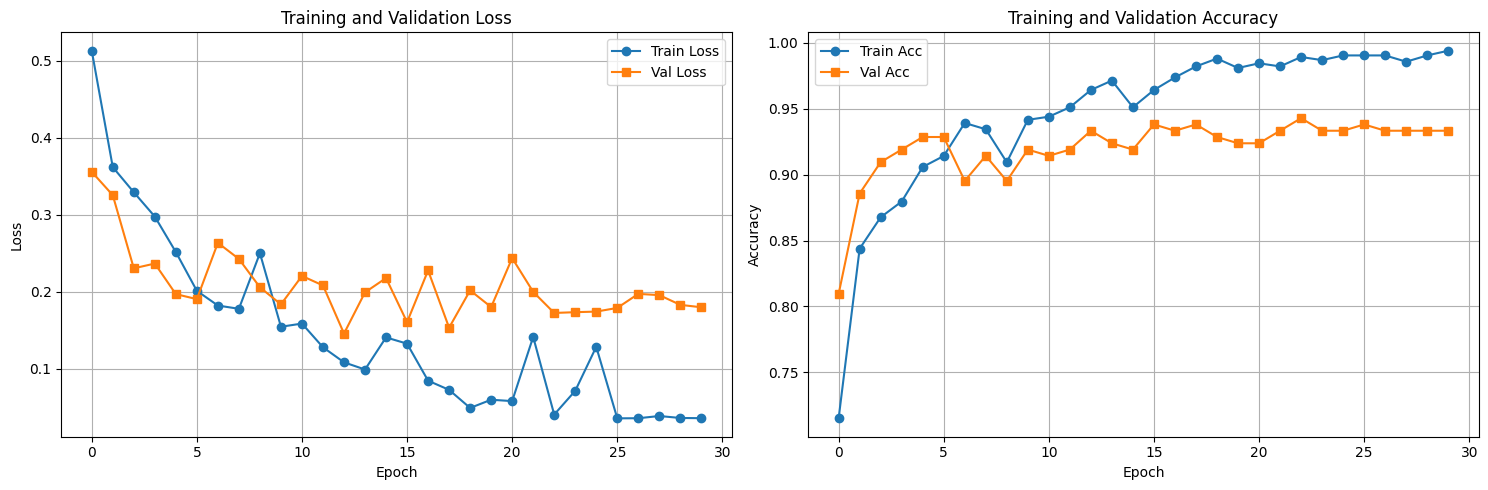


4. Evaluating Best Model...


Testing: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]



TEST SET PERFORMANCE
Accuracy: 0.9316
Precision: 0.9311
Recall: 0.9316
F1-Score: 0.9311
AUC-ROC: 0.9826

Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.96      0.95       179
   malignant       0.91      0.87      0.89        84

    accuracy                           0.93       263
   macro avg       0.93      0.91      0.92       263
weighted avg       0.93      0.93      0.93       263



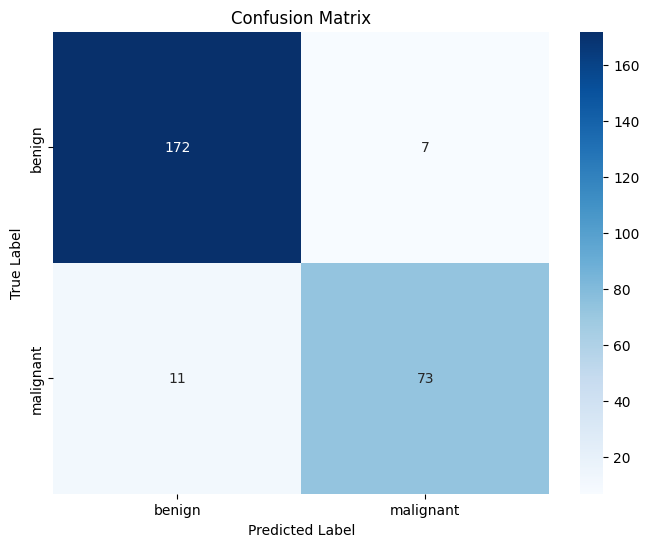

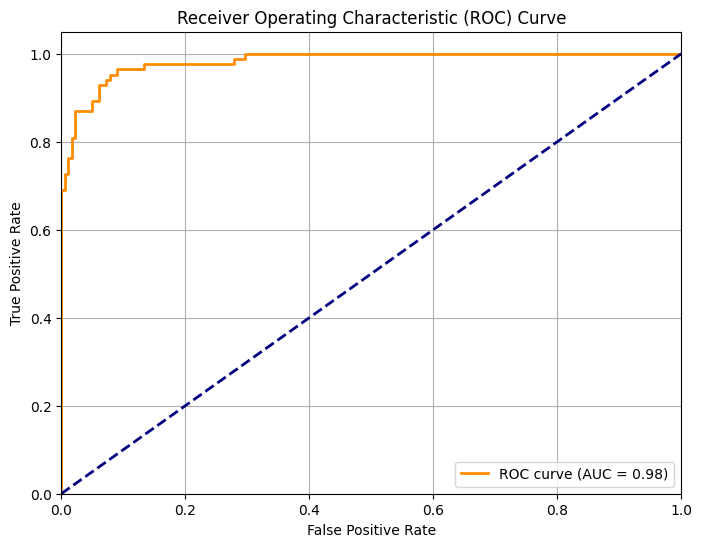


5. Generating XAI Explanations...


  0%|          | 0/1000 [00:00<?, ?it/s]

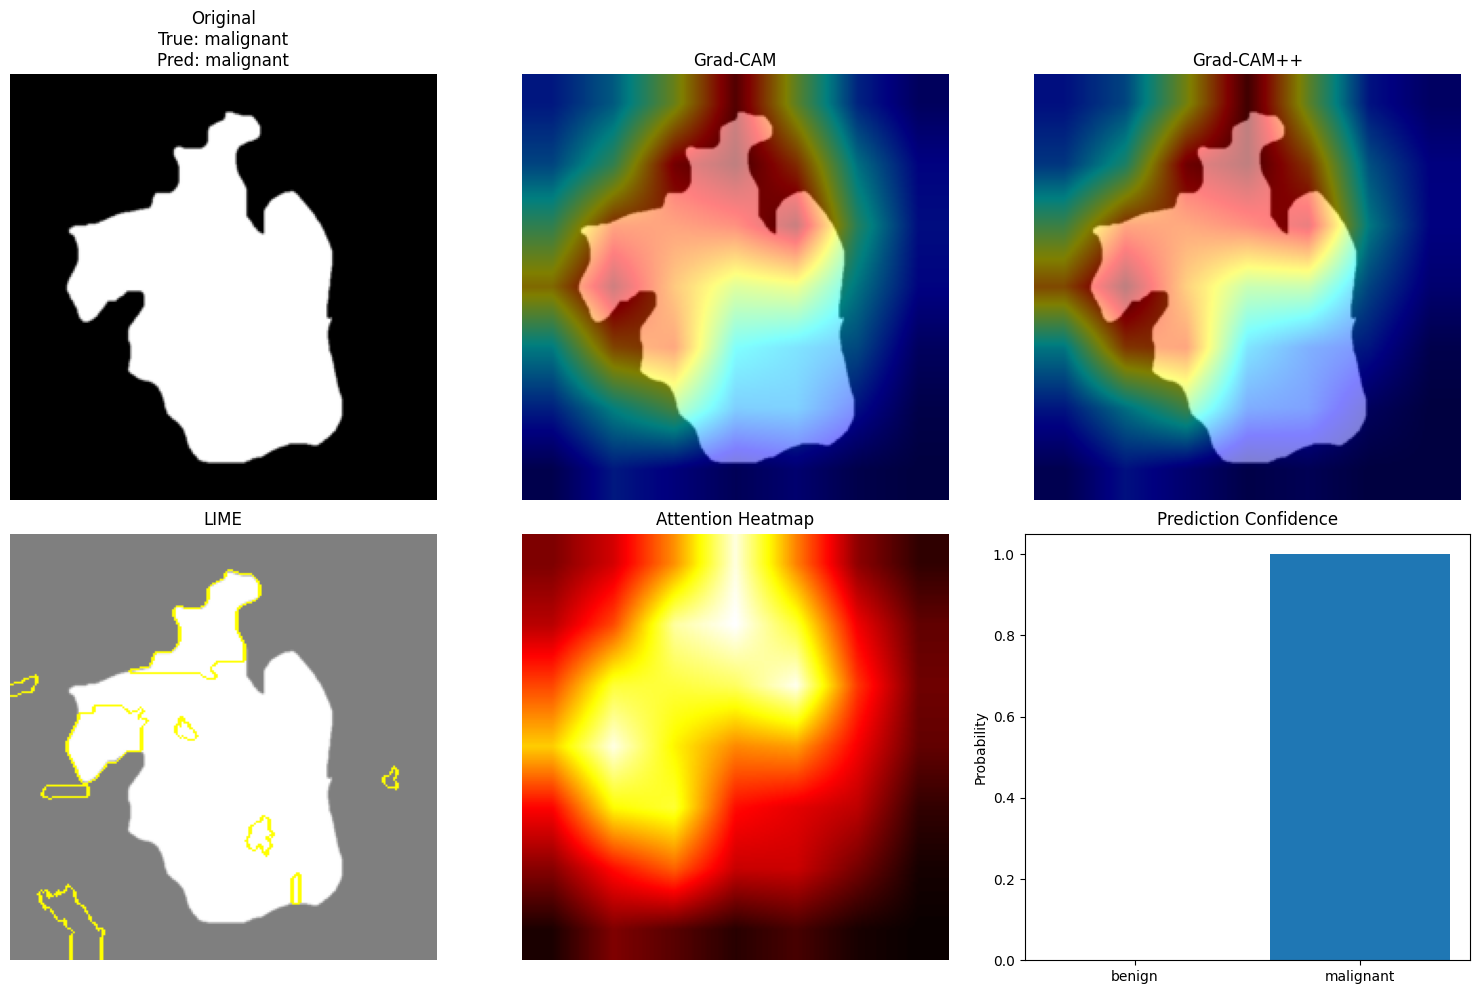

  0%|          | 0/1000 [00:00<?, ?it/s]

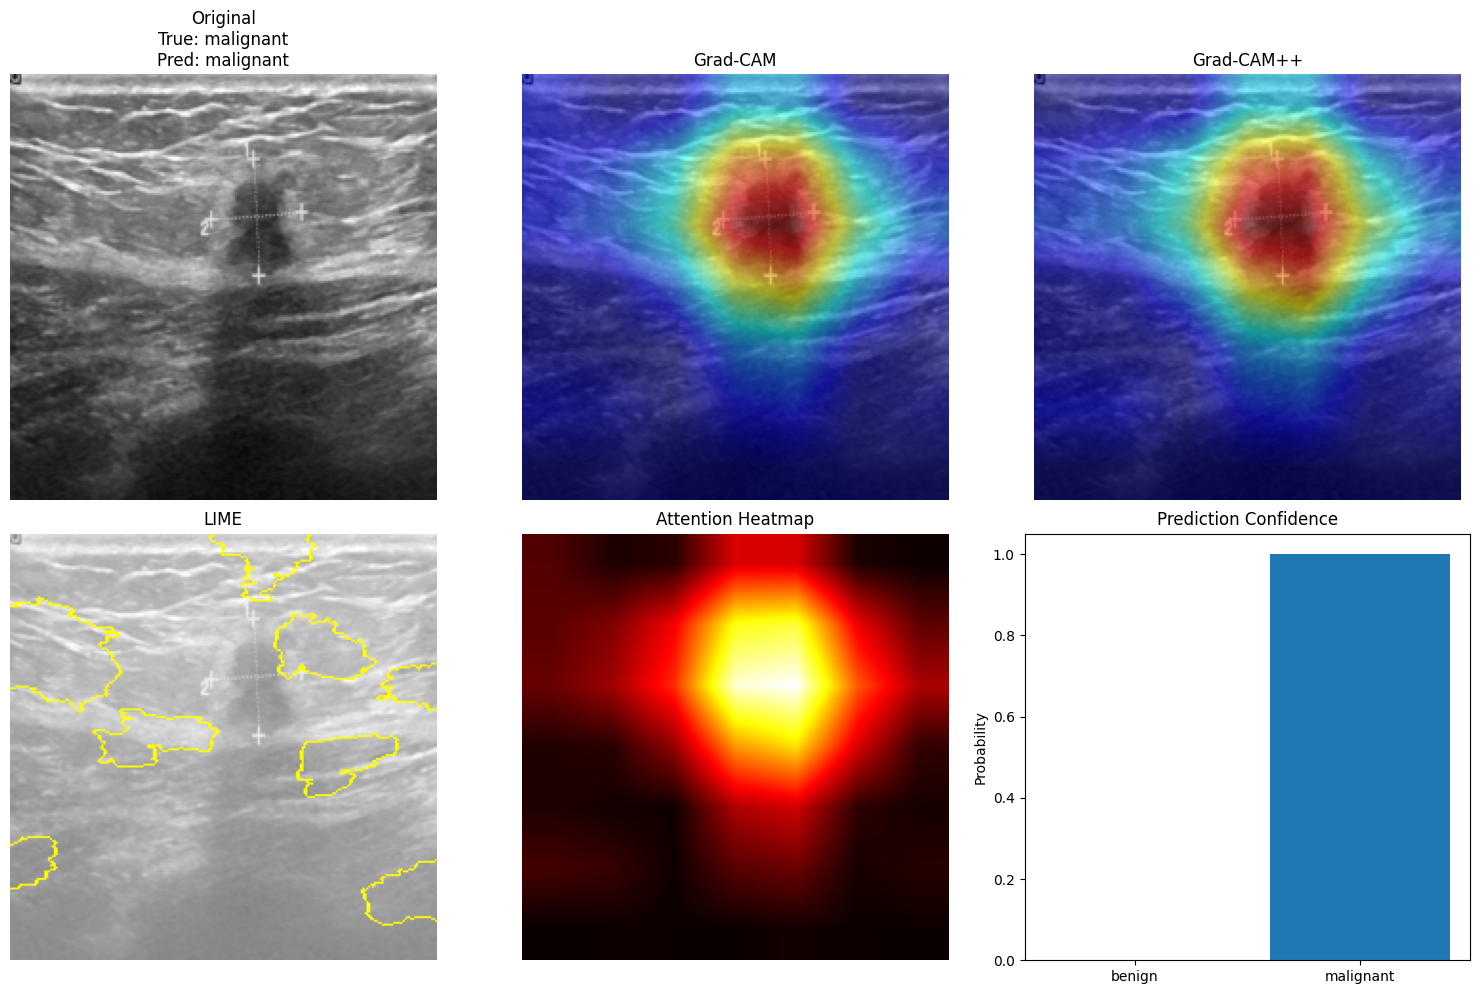

  0%|          | 0/1000 [00:00<?, ?it/s]

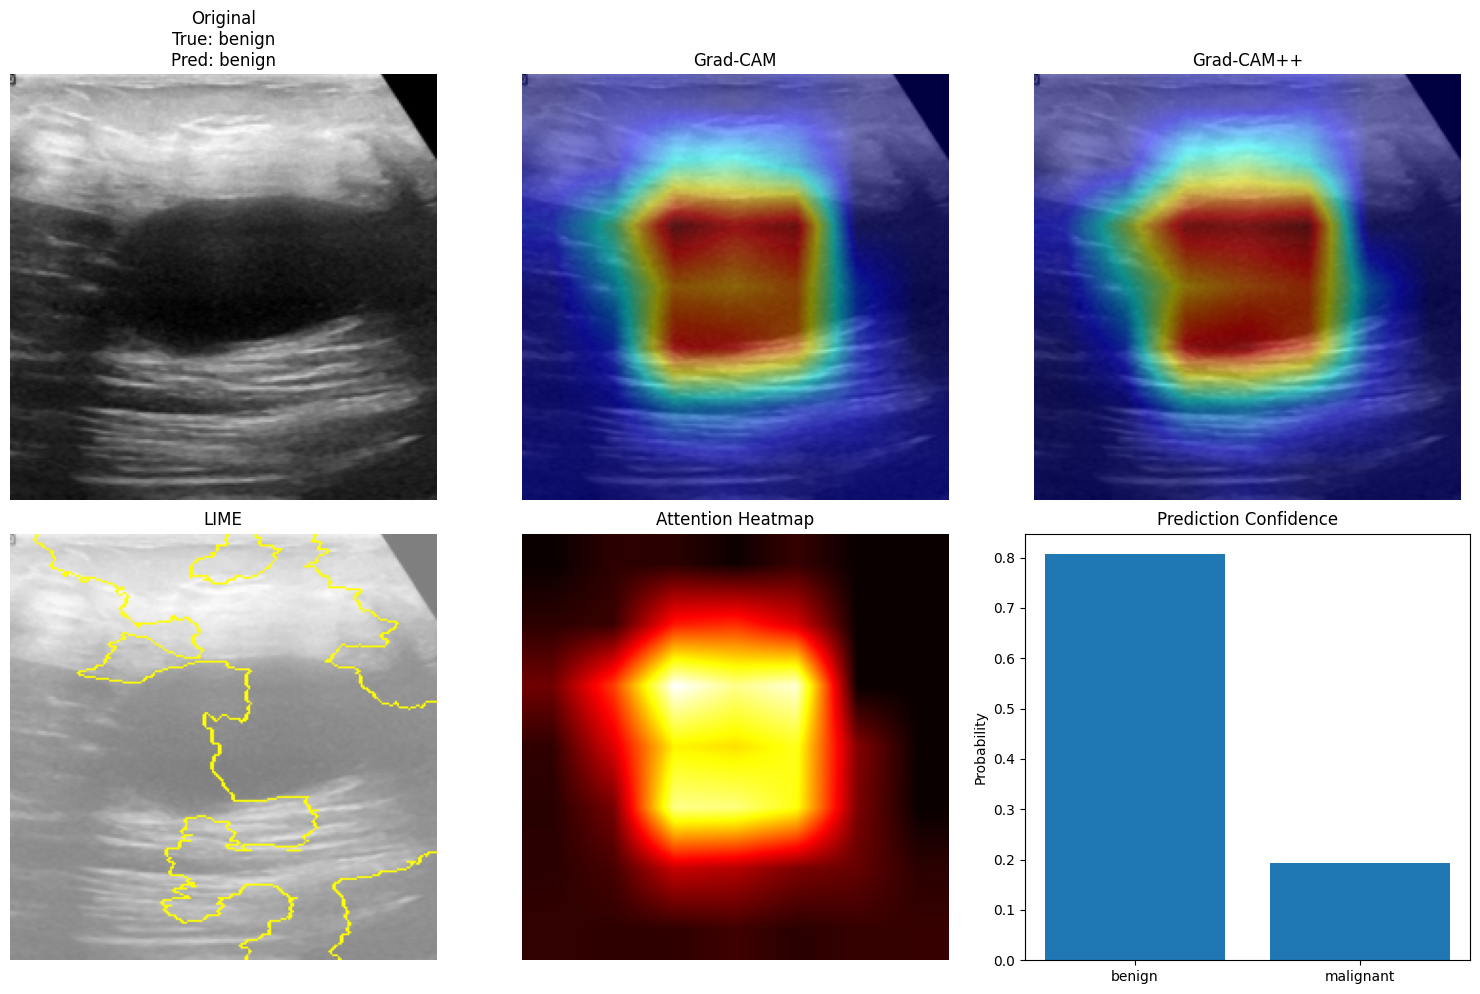


TRAINING COMPLETE!


In [34]:
if __name__ == "__main__":
    # Run the main training pipeline
    model, xai = main()